In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
import matplotlib.pyplot as plt
import numpy as np

### Define constants and paths

In [2]:
out_path = "/users/amtseng/tfmodisco/figures/tfmodisco_pipeline/"
os.makedirs(out_path, exist_ok=True)

In [3]:
rng = np.random.RandomState(20220221)

### Helper functions

In [4]:
revcomp_dict = str.maketrans("ACGT", "TGCA")

def revcomp_seq(seq):
    return seq.translate(revcomp_dict)

def dna_to_one_hot(seqs, out_dtype=np.float64):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    `out_dtype` can be altered to change the datatype of the output one-hot
    sequences. By default, this is `np.float64`, but may be changed to other
    types (e.g. using `out_dtype=np.int8` will drastically reduce memory usage).
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(out_dtype)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [5]:
def one_hot_seq_to_hyp_scores(one_hot_seq, importance, noise_weight=0.2):
    """
    From an N x 4 array of one-hot sequence, and an N-array of which bases are
    important (0, -1, or 1), returns a realistic-looking hypothetical score
    track.
    """
    # The bases that are actually there
    hyp_scores = one_hot_seq * importance[:, None]
    
    # Greatly downweight opposite bases
    hyp_scores = hyp_scores - (np.flip(one_hot_seq, axis=1) * importance[:, None])
    
    # Gently downweight other bases
    hyp_scores = hyp_scores - ((1 - one_hot_seq - np.flip(one_hot_seq, axis=1)) * 0.5 * importance[:, None])
    
    # Add noise
    hyp_scores = hyp_scores + (noise_weight * rng.randn(*one_hot_seq.shape))
    
    return hyp_scores

### Seqlet identification

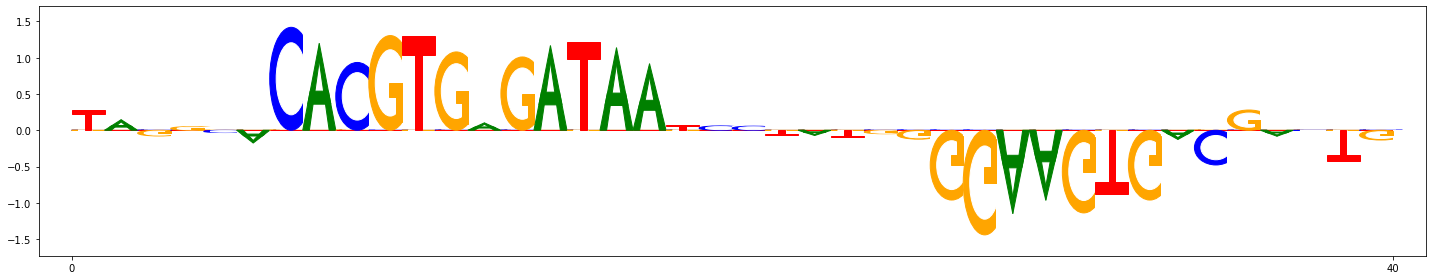

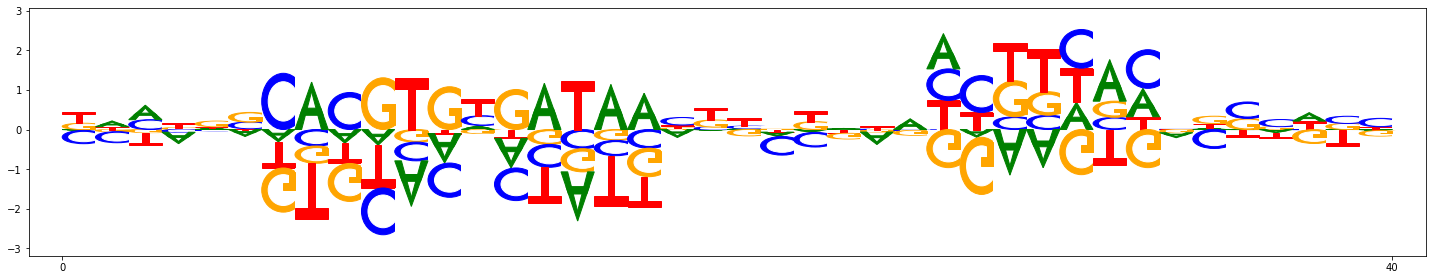

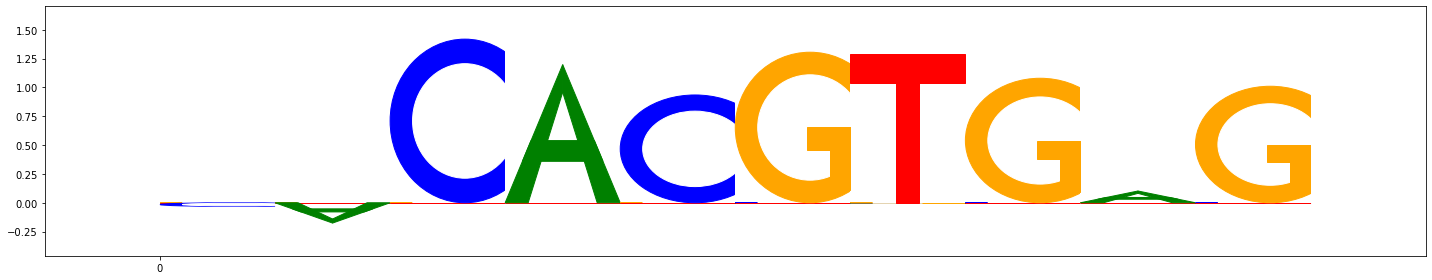

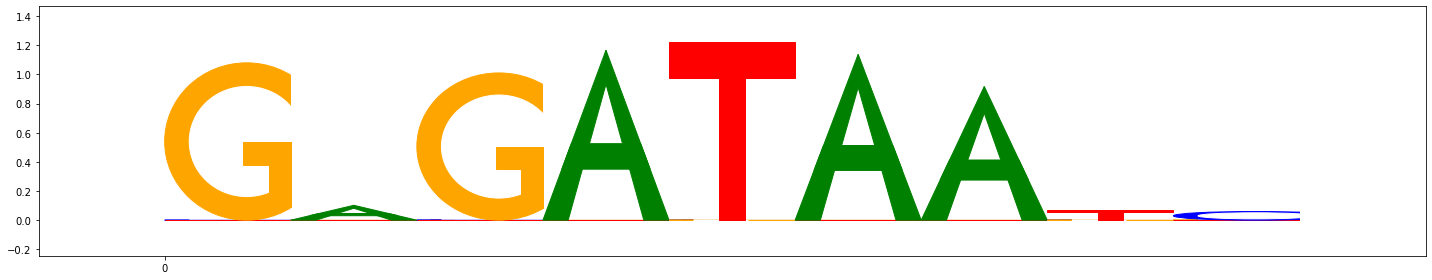

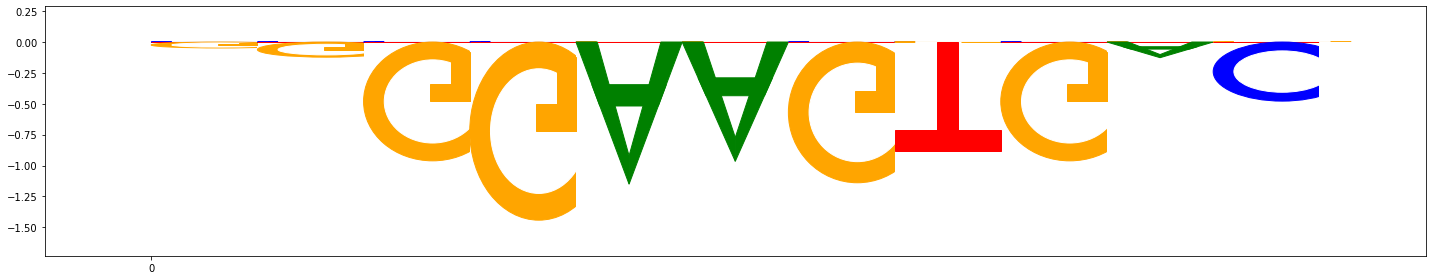

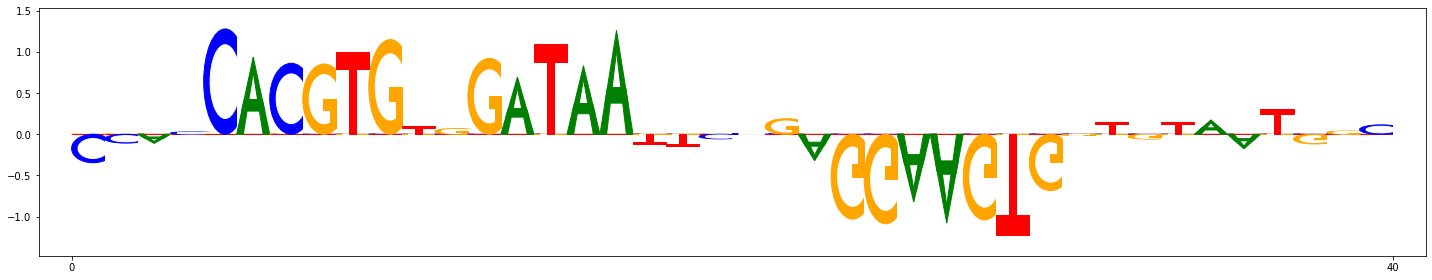

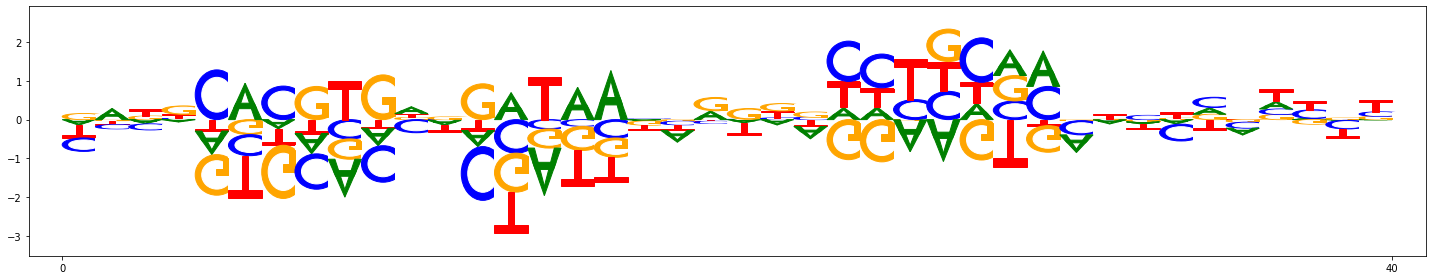

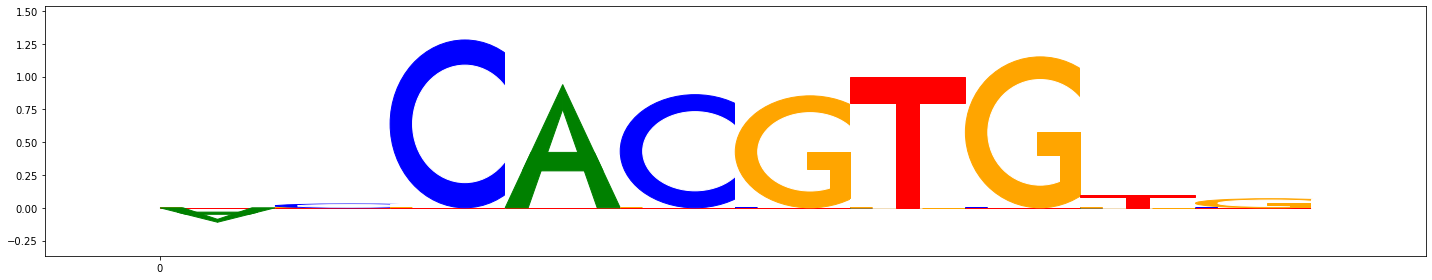

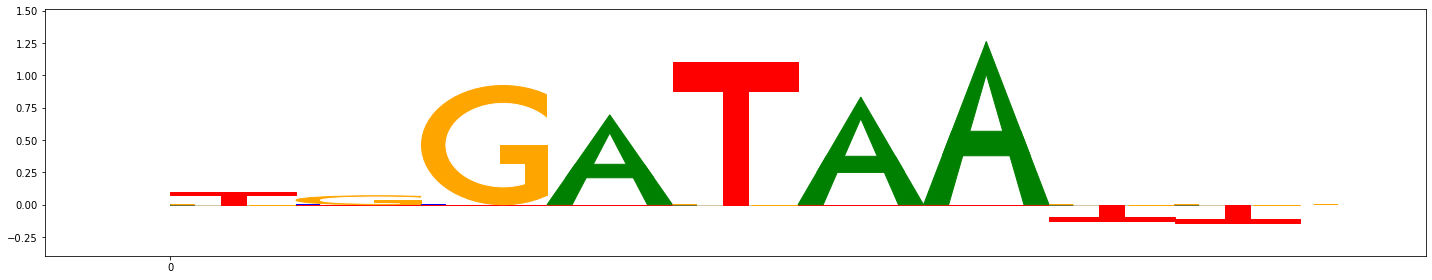

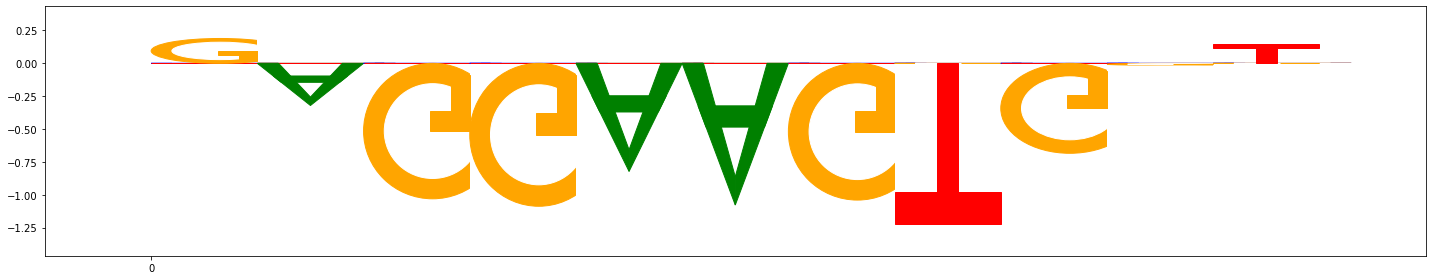

In [6]:
# Example of actual and hypothetical importance scores
num_seqs = 2
seq_len = 40
motifs = ["CACGTG", "GATAA", "GGAAGTG"]
signs = [1, 1, -1]
starts = [5, 15, 25]

for i in range(num_seqs):
    seq = rng.choice(["A", "C", "G", "T"], size=seq_len)
    importance = np.zeros(seq_len)
    
    real_starts = []
    for j in range(len(motifs)):
        motif, sign, start = motifs[j], signs[j], starts[j]
        start += rng.randint(-3, 3)
        real_starts.append(start)
        seq[start : start + len(motif)] = np.array(list(motif))
        importance[start : start + len(motif)] = sign

    one_hot_seq = dna_to_one_hot(["".join(seq)])[0]
    hyp_scores = one_hot_seq_to_hyp_scores(one_hot_seq, importance)
    act_scores = one_hot_seq * hyp_scores

    act_scores_fig = viz_sequence.plot_weights(act_scores, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
    act_scores_fig.tight_layout()
    plt.savefig(
        os.path.join(out_path, "seqlet_identification_act_scores_%d.svg" % i), format="svg"
    )
    plt.show()
    
    hyp_scores_fig = viz_sequence.plot_weights(hyp_scores, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
    hyp_scores_fig.tight_layout()
    plt.savefig(
        os.path.join(out_path, "seqlet_identification_hyp_scores_%d.svg" % i), format="svg"
    )
    plt.show()
    
    for j in range(len(motifs)):
        seqlet_fig = viz_sequence.plot_weights(
            act_scores[real_starts[j] - 2 : real_starts[j] + len(motifs[j]) + 2],
            figsize=(20, 4), subticks_frequency=seq_len, return_fig=True
        )
        seqlet_fig.tight_layout()
        plt.savefig(
            os.path.join(out_path, "seqlet_identification_seqlet_%d-%d.svg" % (i, j)), format="svg"
        )
        plt.show()

### Clustering seqlets in a metacluster

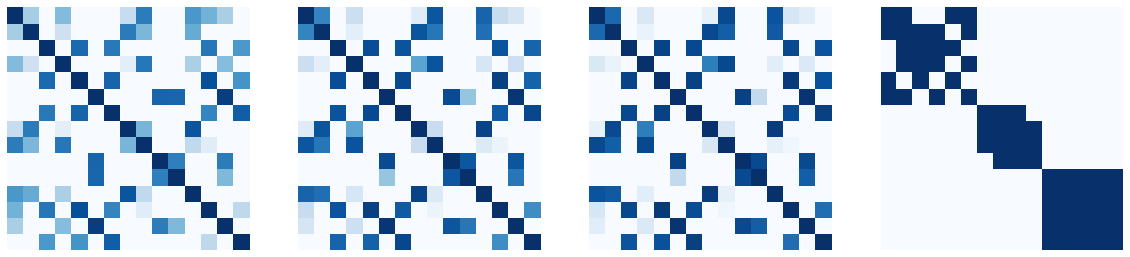

In [7]:
# Similarity matrices
num_rows = 15
cluster_sizes = [6, 4, 5]

clustered_matrix = np.zeros((num_rows, num_rows))

start = 0
for cluster_size in cluster_sizes:
    clustered_matrix[start : start + cluster_size, start : start + cluster_size] = 1
    start += cluster_size
    
mask = rng.choice([0, 1], size=clustered_matrix.shape, p=[0.95, 0.05])
mask = mask + np.transpose(mask) > 0
np.fill_diagonal(mask, 0)

clustered_matrix = clustered_matrix - ((clustered_matrix > 0) & mask)
noise = 0.2 * np.abs(rng.randn(*mask.shape))
np.fill_diagonal(noise, 0)
noise[clustered_matrix == 1] *= -1
noise[~mask & (clustered_matrix == 0)] = 0
noise = noise + np.transpose(noise)
clustered_matrix_with_noise_1 = clustered_matrix + noise
clustered_matrix_with_noise_2 = clustered_matrix + noise / 2
clustered_matrix_with_noise_3 = clustered_matrix + noise / 3

scrambled_inds = rng.permutation(num_rows)
unclustered_matrix = clustered_matrix[scrambled_inds][:, scrambled_inds]
unclustered_matrix_with_noise_1 = clustered_matrix_with_noise_1[scrambled_inds][:, scrambled_inds]
unclustered_matrix_with_noise_2 = clustered_matrix_with_noise_2[scrambled_inds][:, scrambled_inds]
unclustered_matrix_with_noise_3 = clustered_matrix_with_noise_3[scrambled_inds][:, scrambled_inds]

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
ax[0].pcolormesh(np.flip(unclustered_matrix_with_noise_1, axis=0), cmap="Blues")
ax[1].pcolormesh(np.flip(unclustered_matrix_with_noise_2, axis=0), cmap="Blues")
ax[2].pcolormesh(np.flip(unclustered_matrix_with_noise_3, axis=0), cmap="Blues")
ax[3].pcolormesh(np.flip(clustered_matrix, axis=0), cmap="Blues")
for a in ax:
    a.axis("off")
    a.axis("image")

plt.savefig(
    os.path.join(out_path, "clustering_matrices.svg"), format="svg"
)
plt.show()

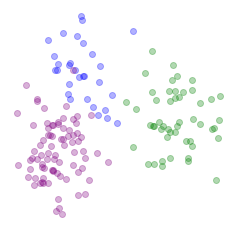

In [8]:
# Leiden scatterplot
centers = np.array([
    [-2, 2],
    [3, 0],
    [-3, -1]
])

cluster_sizes = [30, 50, 80]
colors = ["blue", "green", "purple"]

fig, ax = plt.subplots(figsize=(4, 4))

for i, cluster_size in enumerate(cluster_sizes):
    points = centers[i] + rng.randn(cluster_size, 2)
    ax.scatter(points[:, 0], points[:, 1], color=colors[i], alpha=0.3)
ax.axis("off")
plt.savefig(
    os.path.join(out_path, "clustering_leiden.svg"), format="svg"
)
plt.show()

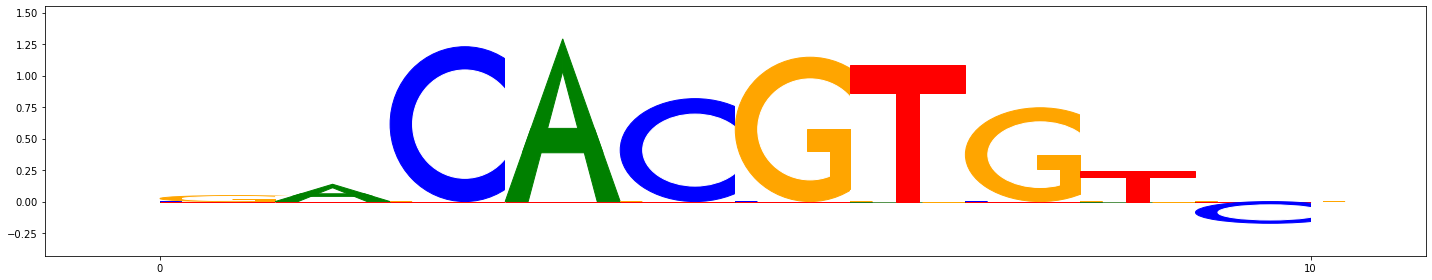

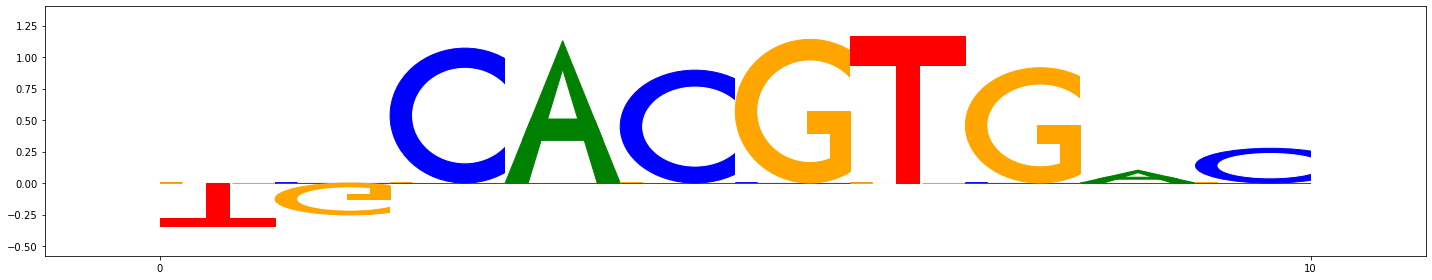

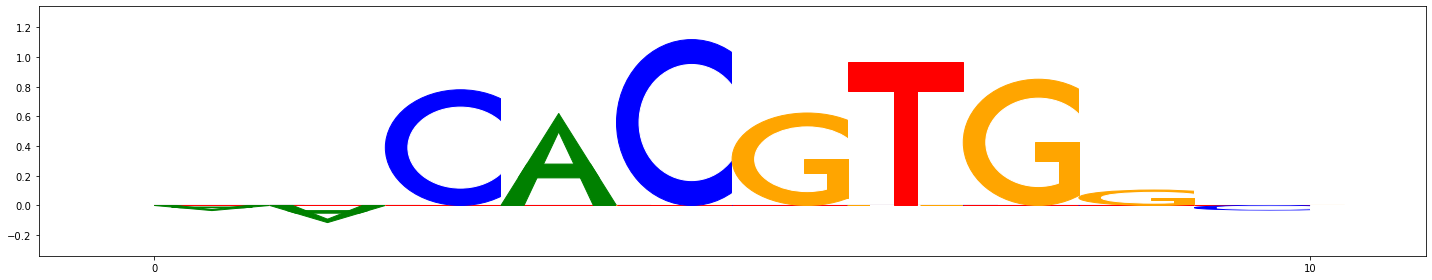

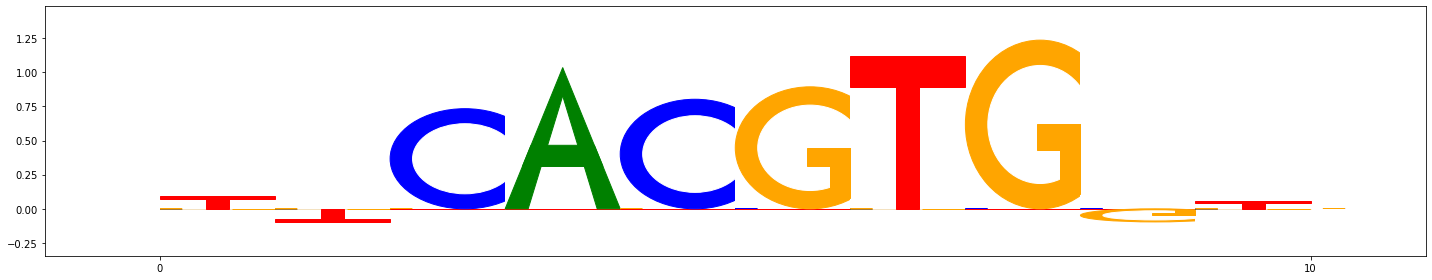

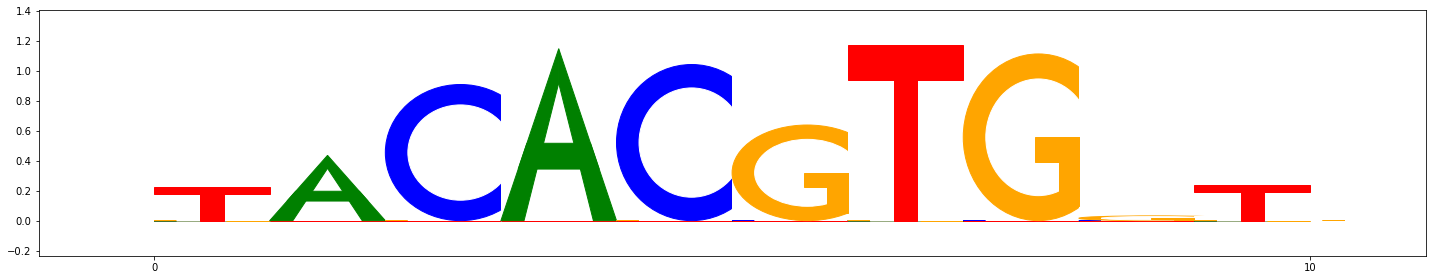

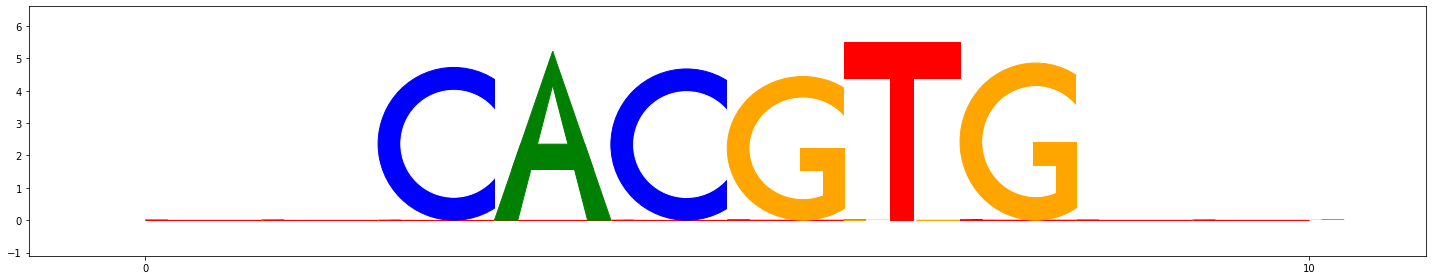

In [9]:
# Example seqlets
motif = "CACGTG"

num_seqlets = 5
flank_size = 2
seq_len = len(motif) + (2 * flank_size)

seqlets = []
for i in range(num_seqlets):
    seq = rng.choice(["A", "C", "G", "T"], size=seq_len)
    importance = np.zeros(seq_len)
    
    seq[flank_size : flank_size + len(motif)] = np.array(list(motif))
    importance[flank_size : flank_size + len(motif)] = 1
    importance = importance + (0.2 * rng.randn(len(importance)))
    
    seqlet = dna_to_one_hot(["".join(seq)])[0] * importance[:, None]
    seqlets.append(seqlet)
    
    seqlet_fig = viz_sequence.plot_weights(seqlet, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
    seqlet_fig.tight_layout()
    plt.savefig(
        os.path.join(out_path, "clustering_seqlet_%d.svg" % i), format="svg"
    )
    plt.show()
    
# Final motif
agg_seqlet = sum(seqlets)
agg_seqlet[:flank_size] = 0
agg_seqlet[-flank_size:] = 0
agg_seqlet_fig = viz_sequence.plot_weights(agg_seqlet, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
agg_seqlet_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_seqlet_agg.svg"), format="svg"
)
plt.show()

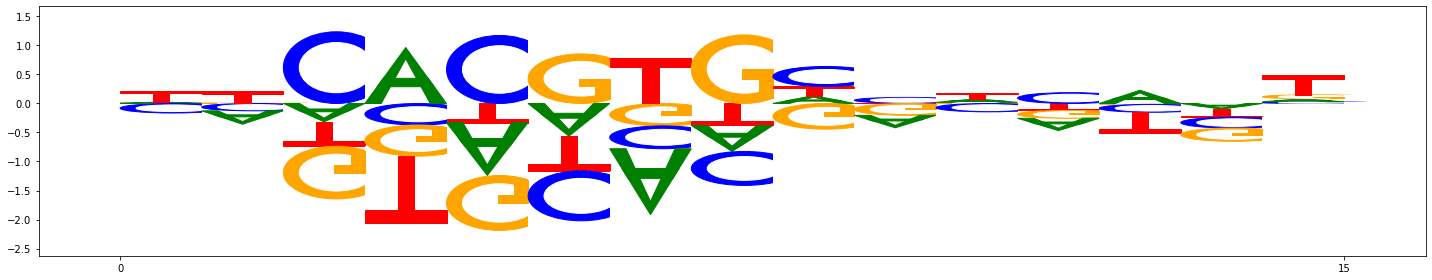

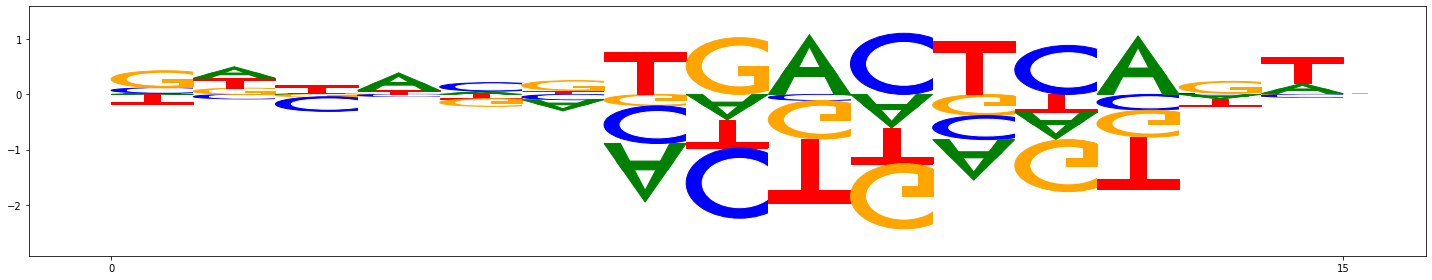

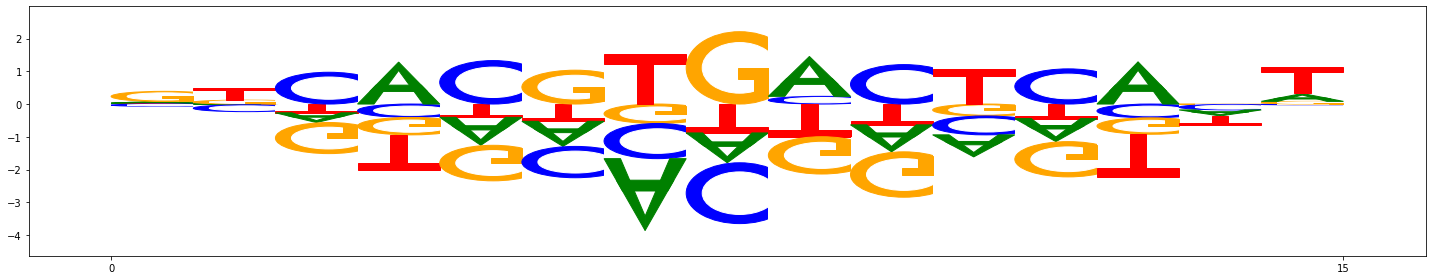

In [10]:
# Splitting
seq_len = 15
split_motif_1 = "CACGTG"
split_motif_2 = "TGACTCA"
start_1 = 2
start_2 = 6

seq_1 = rng.choice(["A", "C", "G", "T"], size=seq_len)
seq_2 = rng.choice(["A", "C", "G", "T"], size=seq_len)
importance_1 = np.zeros(seq_len)
importance_2 = np.zeros(seq_len)

seq_1[start_1 : start_1 + len(split_motif_1)] = np.array(list(split_motif_1))
importance_1[start_1 : start_1 + len(split_motif_1)] = 1
seq_2[start_2 : start_2 + len(split_motif_2)] = np.array(list(split_motif_2))
importance_2[start_2 : start_2 + len(split_motif_2)] = 1

one_hot_seq_1 = dna_to_one_hot(["".join(seq_1)])[0]
one_hot_seq_2 = dna_to_one_hot(["".join(seq_2)])[0]
hyp_scores_1 = one_hot_seq_to_hyp_scores(one_hot_seq_1, importance_1)
hyp_scores_2 = one_hot_seq_to_hyp_scores(one_hot_seq_2, importance_2)

hyp_scores_1_fig = viz_sequence.plot_weights(hyp_scores_1, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_1_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_split_hyp_1.svg"), format="svg"
)
plt.show()

hyp_scores_2_fig = viz_sequence.plot_weights(hyp_scores_2, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_2_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_split_hyp_2.svg"), format="svg"
)
plt.show()

hyp_scores_agg_fig = viz_sequence.plot_weights(hyp_scores_1 + hyp_scores_2, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_agg_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_split_hyp_agg.svg"), format="svg"
)
plt.show()

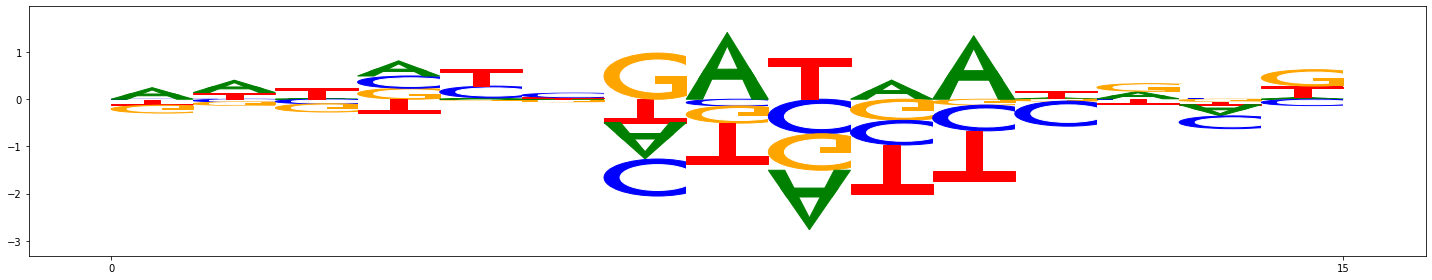

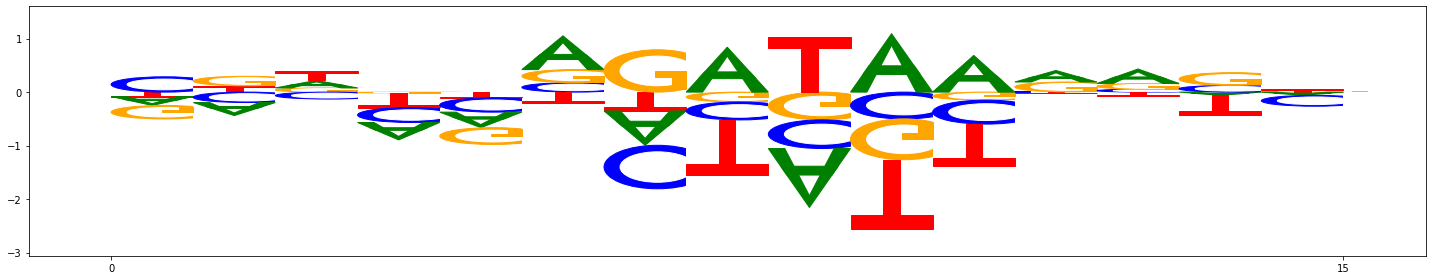

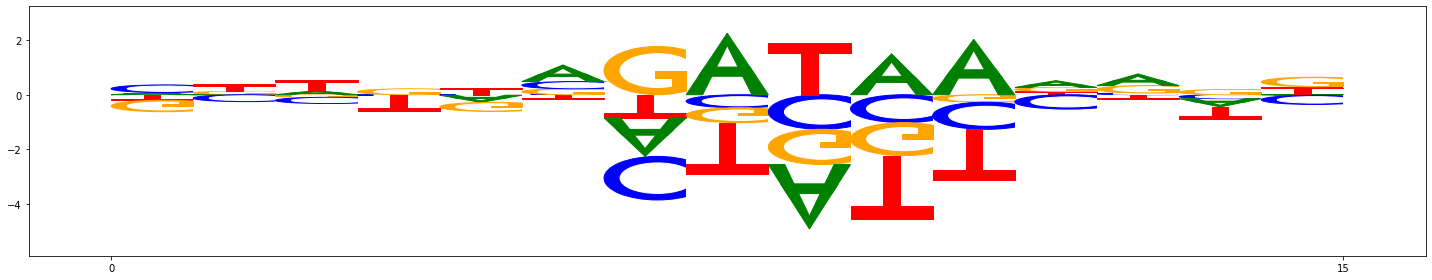

In [11]:
# Merging
seq_len = 15
motif = "GATAA"
start = 6

seq_1 = rng.choice(["A", "C", "G", "T"], size=seq_len)
seq_2 = rng.choice(["A", "C", "G", "T"], size=seq_len)
importance = np.zeros(seq_len)

seq_1[start : start + len(motif)] = np.array(list(motif))
seq_2[start : start + len(motif)] = np.array(list(motif))
importance[start : start + len(motif)] = 1

one_hot_seq_1 = dna_to_one_hot(["".join(seq_1)])[0]
one_hot_seq_2 = dna_to_one_hot(["".join(seq_2)])[0]
hyp_scores_1 = one_hot_seq_to_hyp_scores(one_hot_seq_1, importance)
hyp_scores_2 = one_hot_seq_to_hyp_scores(one_hot_seq_2, importance)

hyp_scores_1_fig = viz_sequence.plot_weights(hyp_scores_1, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_1_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_merge_hyp_1.svg"), format="svg"
)
plt.show()

hyp_scores_2_fig = viz_sequence.plot_weights(hyp_scores_2, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_2_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_merge_hyp_2.svg"), format="svg"
)
plt.show()

hyp_scores_agg_fig = viz_sequence.plot_weights(hyp_scores_1 + hyp_scores_2, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
hyp_scores_agg_fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "clustering_merge_hyp_agg.svg"), format="svg"
)
plt.show()

### Hit scoring

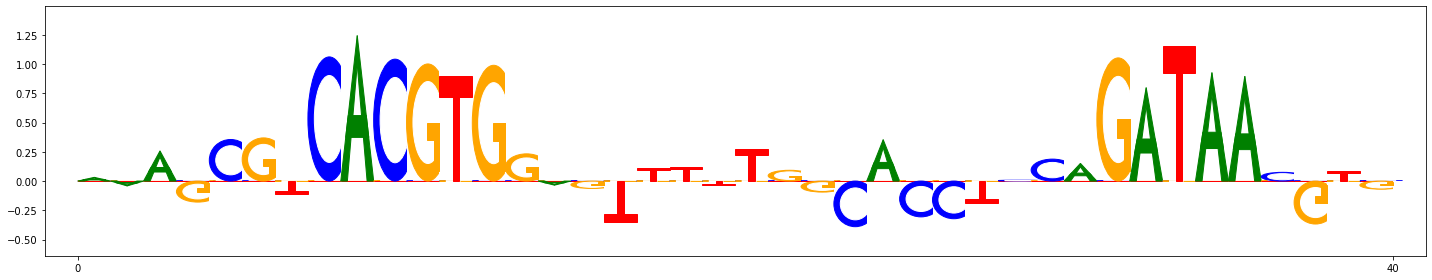

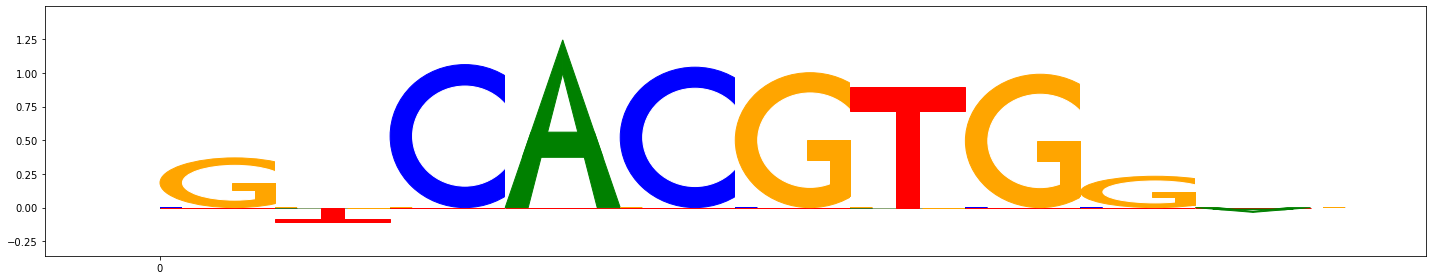

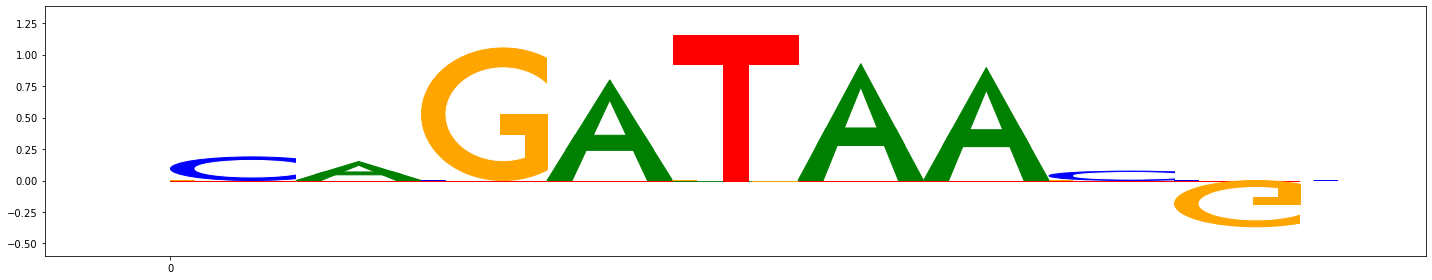

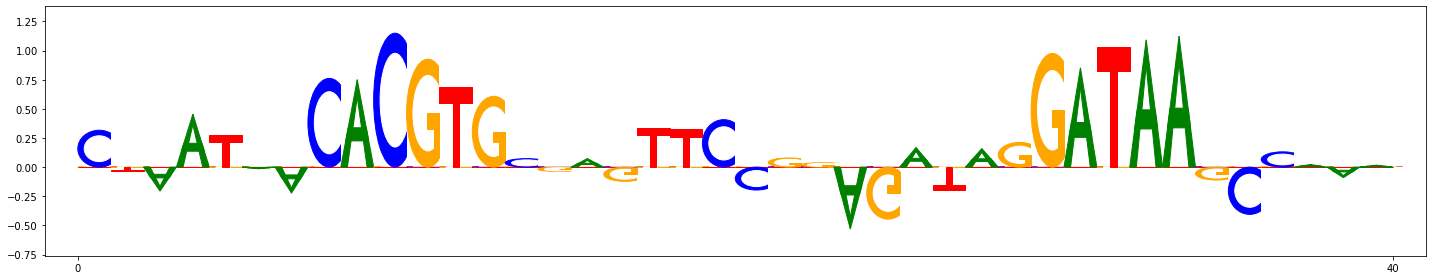

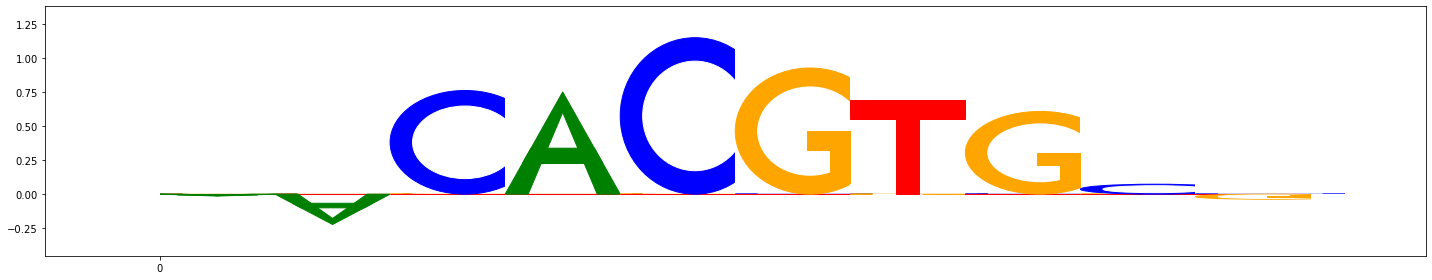

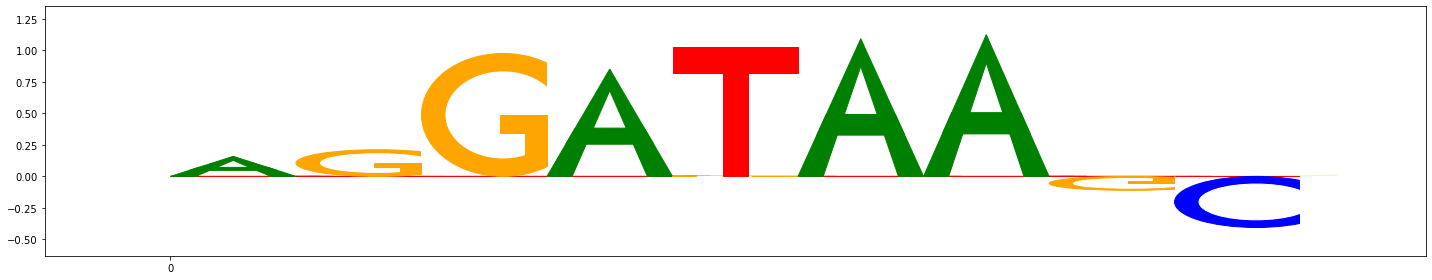

In [12]:
# Example of actual importance scores
num_seqs = 2
seq_len = 40
motifs = ["CACGTG", "GATAA"]
signs = [1, 1]
starts = [10, 30]

for i in range(num_seqs):
    seq = rng.choice(["A", "C", "G", "T"], size=seq_len)
    importance = np.zeros(seq_len)
    
    real_starts = []
    for j in range(len(motifs)):
        motif, sign, start = motifs[j], signs[j], starts[j]
        start += rng.randint(-3, 3)
        real_starts.append(start)
        seq[start : start + len(motif)] = np.array(list(motif))
        importance[start : start + len(motif)] = sign

    one_hot_seq = dna_to_one_hot(["".join(seq)])[0]
    hyp_scores = (one_hot_seq * importance[:, None]) + (-1 * np.flip(one_hot_seq, axis=1) * importance[:, None])
    hyp_scores = hyp_scores + (0.2 * rng.randn(seq_len, 4))
    act_scores = one_hot_seq * hyp_scores
    
    act_scores_fig = viz_sequence.plot_weights(act_scores, figsize=(20, 4), subticks_frequency=seq_len, return_fig=True)
    act_scores_fig.tight_layout()
    plt.savefig(
        os.path.join(out_path, "hit_scoring_act_scores_%d.svg" % i), format="svg"
    )
    plt.show()
    
    for j in range(len(motifs)):
        seqlet_fig = viz_sequence.plot_weights(
            act_scores[real_starts[j] - 2 : real_starts[j] + len(motifs[j]) + 2],
            figsize=(20, 4), subticks_frequency=seq_len, return_fig=True
        )
        seqlet_fig.tight_layout()
        plt.savefig(
            os.path.join(out_path, "hit_scoring_seqlet_%d-%d.svg" % (i, j)), format="svg"
        )
        plt.show()